In [1]:
import tensorflow as tf
import numpy as np
import os, random
import matplotlib.pyplot as plt
import splitfolders
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import pandas as pd
from PIL import Image

#### Split dataset menjadi 3 bagian yaitu train, validation, dan test dengan perbadingan 2 rasio yaitu 70% : 20 % : 10 % dan 80% : 10 % : 10 %

In [2]:
# Directory Utama
main_path = 'Dataset/Data/'
splitfolder_path = 'Dataset/Datav1/Splitdatar1/'
splitfolder_path2 = 'Dataset/Datav1/Splitdatar2/'

### Split Folder cukup dijalankan sekali

In [3]:
# splitfolders.ratio(
#     main_path,
#     output=splitfolder_path,
#     ratio=(0.7, 0.1, 0.2)
# )

# splitfolders.ratio(
#     main_path,
#     output=splitfolder_path2,
#     ratio=(0.8, 0.1, 0.1)
# )

In [4]:
# Directory List
train_path = splitfolder_path + 'train/'
test_path = splitfolder_path + 'test/'
val_path = splitfolder_path + 'val/'

train_path2 = splitfolder_path2 + 'train/'
test_path2 = splitfolder_path2 + 'test/'
val_path2 = splitfolder_path2 + 'val/'

# 4. Preprocessing dan Augmentation
### Proses Normalisasi pada Gambar
> Pada Data Train, Testing dan Validation
- Resize
- preprocess_input
### Proses Augmentasi pada Gambar
> Pada Data Train 
- Rotation
- Vertical Flip
- Horizontal Flip



In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,         
    vertical_flip=True,
    horizontal_flip=True 
)

train_set = train_datagen.flow_from_directory(
    train_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=True, 
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_set = val_datagen.flow_from_directory(
    val_path,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_set = test_datagen.flow_from_directory(
    test_path,                                          
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

train_set2 = train_datagen.flow_from_directory(
    train_path2,
    batch_size=32,
    target_size=(224, 224),
    shuffle=True, 
    class_mode='categorical'
)

val_set2 = val_datagen.flow_from_directory(
    val_path2,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

test_set2 = test_datagen.flow_from_directory(
    test_path2,                                          
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 1400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


## Membuat List Kelas Yang Ada

In [6]:
# List Nama Kelas
class_names = ['Blast', 'Brownspot', 'Healthy', 'Hispa']
class_names

['Blast', 'Brownspot', 'Healthy', 'Hispa']

# 5. Data Analisis dan Visualisasi

## Meta Data

In [7]:
# List untuk mengisi nama kelas dan jumlah data dari masing2 label
file_name = []
tag = []
full_path = []

for path, subdirs, files in os.walk(main_path):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)
        
print("Nama Dataset      : Leaf Diseases")
print("Ukuran Gambar     : [224, 224, 3]")
print("Kelas             :",class_names)
print(f"Total Data        : [{len(tag)}]")
print("====================================")
print("Jumlah Gambar     :")
df = pd.DataFrame({"path":full_path,'file_name':file_name,"Nama":tag})
df.groupby(['Nama']).size()

Nama Dataset      : Leaf Diseases
Ukuran Gambar     : [224, 224, 3]
Kelas             : ['Blast', 'Brownspot', 'Healthy', 'Hispa']
Total Data        : [2000]
Jumlah Gambar     :


Nama
Blast        500
Brownspot    500
Healthy      500
Hispa        500
dtype: int64

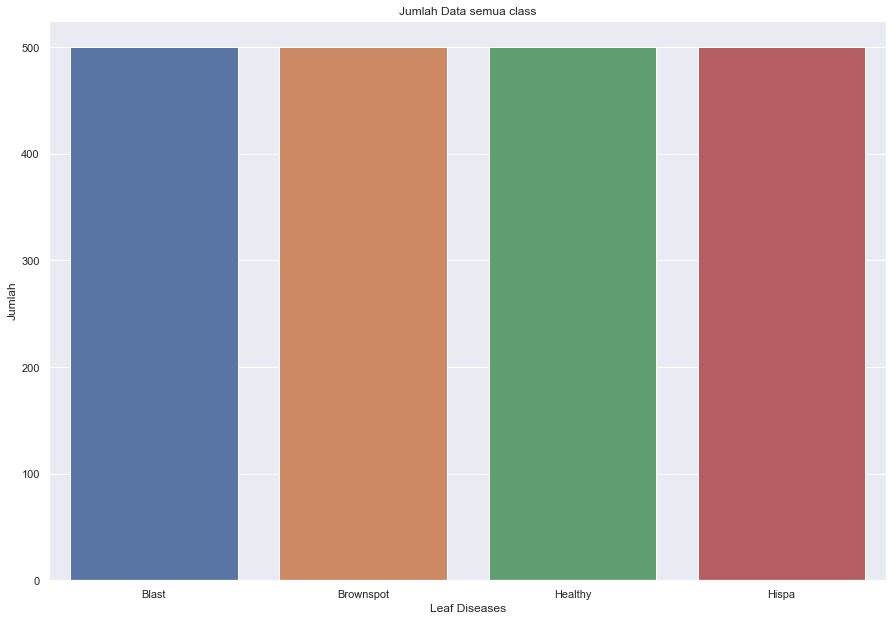

In [8]:
plt.figure(figsize=(15, 35))

sns.set_theme()

plt.subplot(3, 1, 1)
sns.countplot(x=tag)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data semua class')

plt.show()

## Jumlah Data Pada Train, Test Dan Validation Untuk Rasio 7:2:1

In [9]:
file_name_tr = []
file_name_ts = []
file_name_vl = []

TR = []
TS = []
VL = []

full_path_tr = []
full_path_ts = [] 
full_path_vl = []

for path, subdirs, files in os.walk(train_path):
    for name in files:
        full_path_tr.append(os.path.join(path, name)) 
        TR.append(path.split('/')[-1])        
        file_name_tr.append(name)

for path, subdirs, files in os.walk(test_path):
    for name in files:
        full_path_ts.append(os.path.join(path, name)) 
        TS.append(path.split('/')[-1])        
        file_name_ts.append(name)

for path, subdirs, files in os.walk(val_path):
    for name in files:
        full_path_vl.append(os.path.join(path, name)) 
        VL.append(path.split('/')[-1])        
        file_name_vl.append(name)
        
df_tr = pd.DataFrame({"path":full_path_tr,'file_name':file_name_tr,"Train":TR})
df_ts = pd.DataFrame({"path":full_path_ts,'file_name':file_name_ts,"Test":TS})
df_vl = pd.DataFrame({"path":full_path_vl,'file_name':file_name_vl,"Validation":VL})

In [10]:
paths_train = [path.parts[-2:] for path in
        Path(train_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_trainpath = pd.DataFrame(data=paths_train, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_trainpath = df_trainpath.sort_values('Class', ascending=True) #sorting nama Class
df_trainpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_trainpath       

Class                Image
0     Blast  20231006_164402.jpg
1     Blast    leaf_blast212.jpg
2     Blast    leaf_blast207.jpg
3     Blast      leaf_blast2.jpg
4     Blast    leaf_blast193.jpg
...     ...                  ...
1395  Hispa   Rice_Hispa (3).jpg
1396  Hispa  Rice_Hispa (29).jpg
1397  Hispa  Rice_Hispa (27).jpg
1398  Hispa  Rice_Hispa (35).jpg
1399  Hispa    rice_hispa998.jpg

[1400 rows x 2 columns]

In [11]:
paths_test = [path.parts[-2:] for path in
        Path(test_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_testpath = pd.DataFrame(data=paths_test, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_testpath = df_testpath.sort_values('Class', ascending=True) #sorting nama Class
df_testpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_testpath      

Class                   Image
0    Blast  20231006_165844(0).jpg
1    Blast       leaf_blast509.jpg
2    Blast       leaf_blast507.jpg
3    Blast       leaf_blast477.jpg
4    Blast       leaf_blast466.jpg
..     ...                     ...
395  Hispa     Rice_Hispa (64).jpg
396  Hispa     Rice_Hispa (60).jpg
397  Hispa     Rice_Hispa (59).jpg
398  Hispa     Rice_Hispa (94).jpg
399  Hispa       rice_hispa999.jpg

[400 rows x 2 columns]

In [12]:
paths_val = [path.parts[-2:] for path in
        Path(val_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_valpath = pd.DataFrame(data=paths_val, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_valpath = df_valpath.sort_values('Class', ascending=True) #sorting nama Class
df_valpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_valpath       

Class                 Image
0    Blast   20231006_165850.jpg
1    Blast    leaf_blast1675.jpg
2    Blast    leaf_blast1710.jpg
3    Blast    leaf_blast1762.jpg
4    Blast    leaf_blast1770.jpg
..     ...                   ...
195  Hispa    rice_hispa1130.jpg
196  Hispa    rice_hispa1157.jpg
197  Hispa    rice_hispa1238.jpg
198  Hispa  Rice_Hispa (186).jpg
199  Hispa     rice_hispa915.jpg

[200 rows x 2 columns]

In [13]:
train_pie = df_trainpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageTrain")
test_pie = df_testpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageTest")
val_pie = df_valpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageVal")

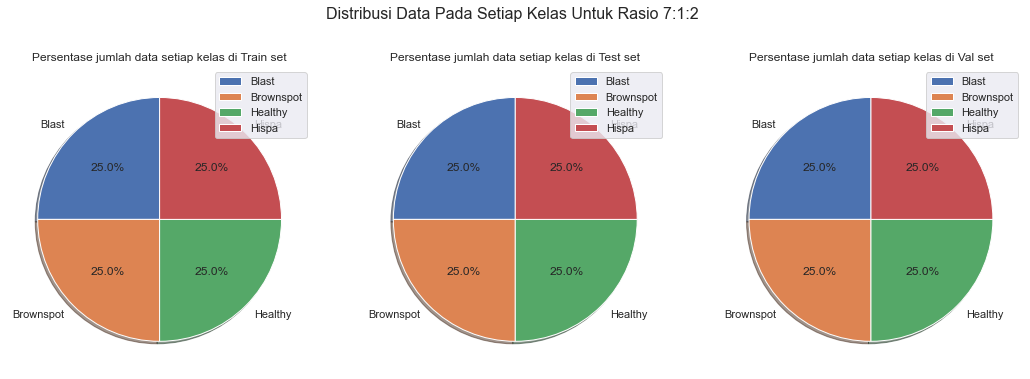

In [14]:
# Membuat figure dengan tiga subplot di dalam satu baris
plt.figure(figsize=(15, 5))

# Subplot pertama untuk Train set
plt.subplot(1, 3, 1)
plt.pie(
    train_pie['ImageTrain'],
    labels=train_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Train set")
plt.legend()

# Subplot kedua untuk Test set
plt.subplot(1, 3, 2)
plt.pie(
    test_pie['ImageTest'],
    labels=test_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Test set")
plt.legend()

# Subplot ketiga untuk Val set
plt.subplot(1, 3, 3)
plt.pie(
    val_pie['ImageVal'],
    labels=val_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Val set")
plt.legend()

plt.suptitle("Distribusi Data Pada Setiap Kelas Untuk Rasio 7:1:2", fontsize=16, y=1.05)

# Menampilkan plot
plt.tight_layout()
plt.show()


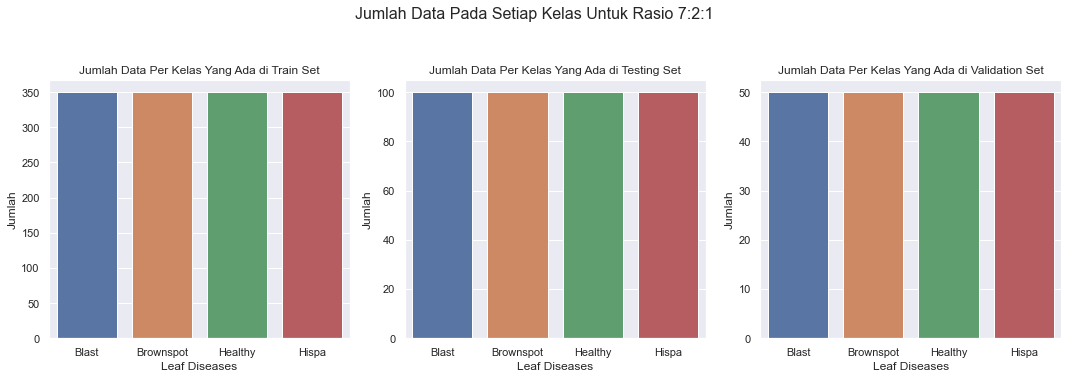

In [15]:
# Membuat figure dengan tiga subplot dalam satu baris
plt.figure(figsize=(15, 5))

# Diagram Bar untuk Train set
plt.subplot(1, 3, 1)
sns.countplot(x=TR)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Train Set')

# Diagram Bar untuk Test set
plt.subplot(1, 3, 2)
sns.countplot(x=TS)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Testing Set')

# Diagram Bar untuk Validation set
plt.subplot(1, 3, 3)
sns.countplot(x=VL)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Validation Set')

plt.suptitle("Jumlah Data Pada Setiap Kelas Untuk Rasio 7:2:1", fontsize=16, y=1.05)
# Menampilkan plot
plt.tight_layout()
plt.show()


## Jumlah Data Pada Train, Test Dan Validation Untuk Rasio 8:1:1

In [16]:
file_name_tr = []
file_name_ts = []
file_name_vl = []

TR = []
TS = []
VL = []

full_path_tr = []
full_path_ts = [] 
full_path_vl = []

for path, subdirs, files in os.walk(train_path2):
    for name in files:
        full_path_tr.append(os.path.join(path, name)) 
        TR.append(path.split('/')[-1])        
        file_name_tr.append(name)

for path, subdirs, files in os.walk(test_path2):
    for name in files:
        full_path_ts.append(os.path.join(path, name)) 
        TS.append(path.split('/')[-1])        
        file_name_ts.append(name)

for path, subdirs, files in os.walk(val_path2):
    for name in files:
        full_path_vl.append(os.path.join(path, name)) 
        VL.append(path.split('/')[-1])        
        file_name_vl.append(name)
        
df_tr = pd.DataFrame({"path":full_path_tr,'file_name':file_name_tr,"Train":TR})
df_ts = pd.DataFrame({"path":full_path_ts,'file_name':file_name_ts,"Test":TS})
df_vl = pd.DataFrame({"path":full_path_vl,'file_name':file_name_vl,"Validation":VL})

In [17]:
paths_train = [path.parts[-2:] for path in
        Path(train_path2).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_trainpath = pd.DataFrame(data=paths_train, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_trainpath = df_trainpath.sort_values('Class', ascending=True) #sorting nama Class
df_trainpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_trainpath       

Class                Image
0     Blast  20231006_164402.jpg
1     Blast    leaf_blast226.jpg
2     Blast    leaf_blast225.jpg
3     Blast    leaf_blast222.jpg
4     Blast    leaf_blast212.jpg
...     ...                  ...
1595  Hispa  Rice_Hispa (30).jpg
1596  Hispa   Rice_Hispa (3).jpg
1597  Hispa  Rice_Hispa (29).jpg
1598  Hispa  Rice_Hispa (38).jpg
1599  Hispa    rice_hispa998.jpg

[1600 rows x 2 columns]

In [18]:
paths_test = [path.parts[-2:] for path in
        Path(test_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_testpath = pd.DataFrame(data=paths_test, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_testpath = df_testpath.sort_values('Class', ascending=True) #sorting nama Class
df_testpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_testpath      

Class                   Image
0    Blast  20231006_165844(0).jpg
1    Blast       leaf_blast509.jpg
2    Blast       leaf_blast507.jpg
3    Blast       leaf_blast477.jpg
4    Blast       leaf_blast466.jpg
..     ...                     ...
395  Hispa     Rice_Hispa (64).jpg
396  Hispa     Rice_Hispa (60).jpg
397  Hispa     Rice_Hispa (59).jpg
398  Hispa     Rice_Hispa (94).jpg
399  Hispa       rice_hispa999.jpg

[400 rows x 2 columns]

In [19]:
paths_val = [path.parts[-2:] for path in
        Path(val_path).rglob('*.*')] #*.* agar semua format gambar bisa diambil

df_valpath = pd.DataFrame(data=paths_val, columns=['Class', 'Image']) #membuat nama koloom utk dataframe
df_valpath = df_valpath.sort_values('Class', ascending=True) #sorting nama Class
df_valpath.reset_index(drop=True, inplace=True) #sorting indeks setiap baris
df_valpath       

Class                 Image
0    Blast   20231006_165850.jpg
1    Blast    leaf_blast1675.jpg
2    Blast    leaf_blast1710.jpg
3    Blast    leaf_blast1762.jpg
4    Blast    leaf_blast1770.jpg
..     ...                   ...
195  Hispa    rice_hispa1130.jpg
196  Hispa    rice_hispa1157.jpg
197  Hispa    rice_hispa1238.jpg
198  Hispa  Rice_Hispa (186).jpg
199  Hispa     rice_hispa915.jpg

[200 rows x 2 columns]

In [20]:
train_pie = df_trainpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageTrain")
test_pie = df_testpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageTest")
val_pie = df_valpath['Class'].value_counts().rename_axis("Class").reset_index(name="ImageVal")

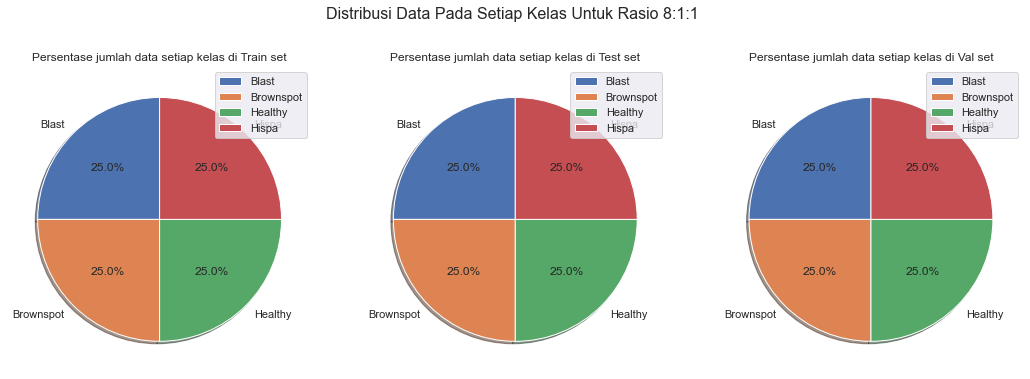

In [21]:
# Membuat figure dengan tiga subplot di dalam satu baris
plt.figure(figsize=(15, 5))

# Subplot pertama untuk Train set
plt.subplot(1, 3, 1)
plt.pie(
    train_pie['ImageTrain'],
    labels=train_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Train set")
plt.legend()

# Subplot kedua untuk Test set
plt.subplot(1, 3, 2)
plt.pie(
    test_pie['ImageTest'],
    labels=test_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Test set")
plt.legend()

# Subplot ketiga untuk Val set
plt.subplot(1, 3, 3)
plt.pie(
    val_pie['ImageVal'],
    labels=val_pie['Class'],
    startangle=90,
    autopct='%.1f%%',
    shadow=True
)
plt.title("Persentase jumlah data setiap kelas di Val set")
plt.legend()

plt.suptitle("Distribusi Data Pada Setiap Kelas Untuk Rasio 8:1:1", fontsize=16, y=1.05)

# Menampilkan plot
plt.tight_layout()
plt.show()


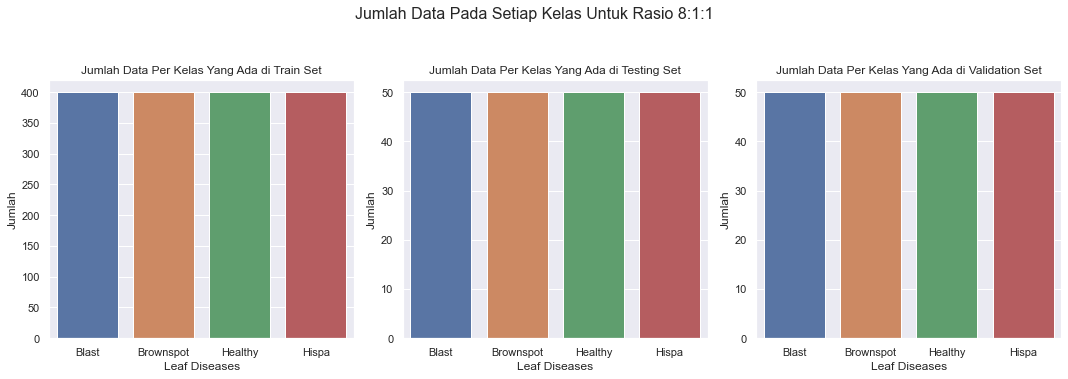

In [22]:
# Membuat figure dengan tiga subplot dalam satu baris
plt.figure(figsize=(15, 5))

# Diagram Bar untuk Train set
plt.subplot(1, 3, 1)
sns.countplot(x=TR)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Train Set')

# Diagram Bar untuk Test set
plt.subplot(1, 3, 2)
sns.countplot(x=TS)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Testing Set')

# Diagram Bar untuk Validation set
plt.subplot(1, 3, 3)
sns.countplot(x=VL)
plt.xlabel('Leaf Diseases')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Per Kelas Yang Ada di Validation Set')

plt.suptitle("Jumlah Data Pada Setiap Kelas Untuk Rasio 8:1:1", fontsize=16, y=1.05)
# Menampilkan plot
plt.tight_layout()
plt.show()


## Visualisasi Preprocessing Dan Augmentasi

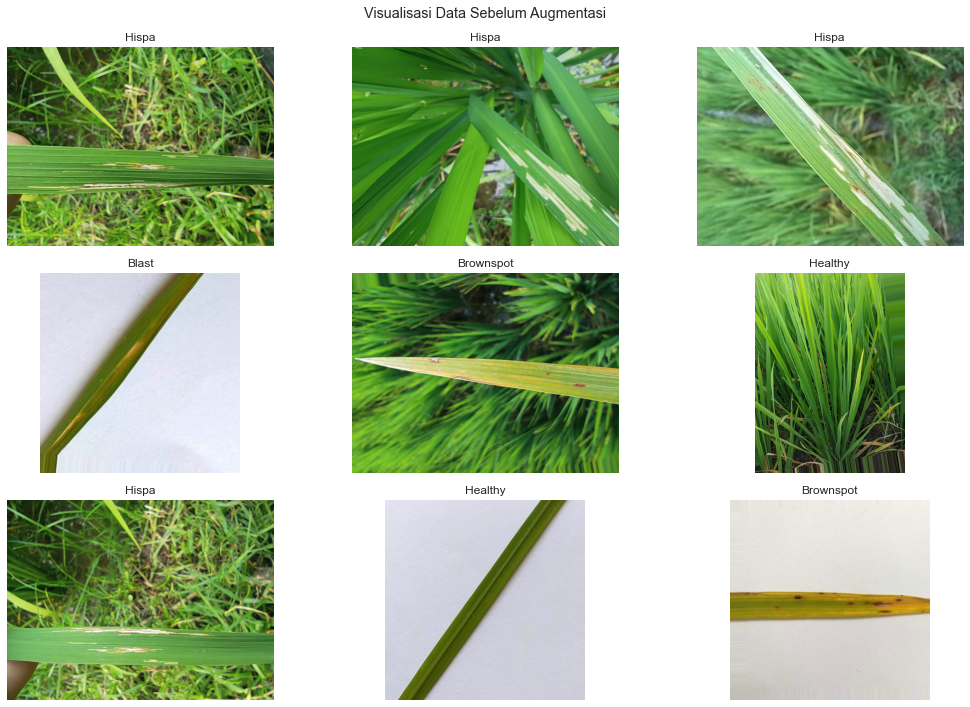

In [23]:
# Ambil nama folder yang merepresentasikan kelas (pastikan ini adalah folder, bukan file)
classes = [folder for folder in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, folder))]

# Dictionary untuk menyimpan path gambar tiap kelas
class_images = {}

# Mengumpulkan path semua gambar per kelas
for class_name in classes:
    class_folder = os.path.join(main_path, class_name)
    image_files = os.listdir(class_folder)
    
    # Simpan tuple (path_gambar, label_kelas)
    class_images[class_name] = [(os.path.join(class_folder, img_file), class_name) for img_file in image_files]

# Ambil minimal 1 gambar dari tiap kelas
selected_images = []

for class_name in class_images:
    selected_images.append(random.choice(class_images[class_name]))

# Ambil sisa gambar acak dari semua kelas untuk melengkapi total 9 gambar
remaining_images = []

for class_name in class_images:
    remaining_images.extend(class_images[class_name])

# Hapus yang sudah dipilih agar tidak duplikat
remaining_images = list(set(remaining_images) - set(selected_images))

# Shuffle dan ambil sisa gambar untuk melengkapi total 9
random.shuffle(remaining_images)
selected_images.extend(remaining_images[:9 - len(selected_images)])

# Shuffle ulang seluruh 9 gambar agar urutan acak
random.shuffle(selected_images)

# Tampilkan 9 gambar
plt.figure(figsize=(15, 10))
plt.suptitle('Visualisasi Data Sebelum Augmentasi')

for i, (img_path, label) in enumerate(selected_images):
    img = Image.open(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

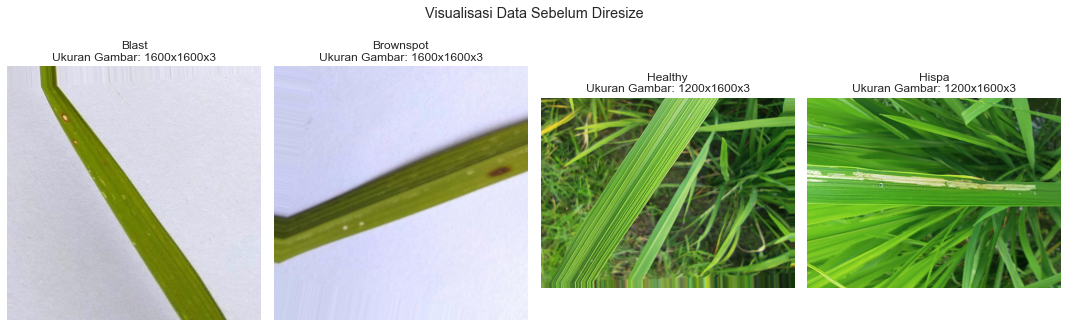

In [24]:
selected_images = []

# Loop untuk setiap kelas
for class_name in class_names:
    class_dir = os.path.join(main_path, class_name)  # Path folder kelas
    image_files = os.listdir(class_dir)  # Ambil semua file dalam folder
    image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter gambar
    
    # Ambil satu gambar secara acak dari kelas
    if image_files:
        selected_file = random.choice(image_files)  # Acak 1 file
        image_path = os.path.join(class_dir, selected_file)
        selected_images.append((image_path, class_name))

plt.figure(figsize=(15, 5))
plt.suptitle('Visualisasi Data Sebelum Diresize')

for i, (img_path, label) in enumerate(selected_images):
    img = Image.open(img_path)
    img_np = np.array(img)
    
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f'{label}\nUkuran Gambar: {img_np.shape[0]}x{img_np.shape[1]}x{img_np.shape[2]}')

plt.tight_layout()
plt.show()

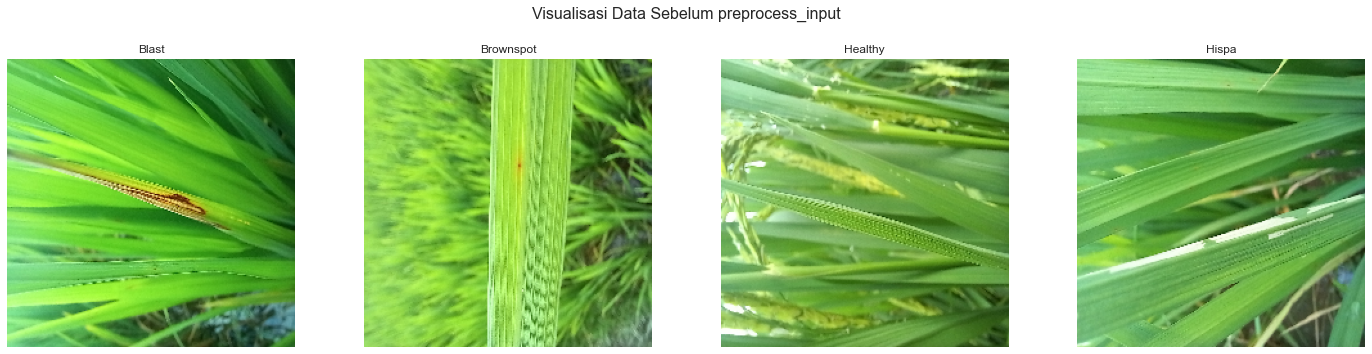

===== ARRAY SEBELUM preprocess_input =====

[Blast]
➤ Array :
[[[160. 154.  16.]
  [167. 167.  21.]
  [180. 190.  31.]]

 [[ 73.  36.   0.]
  [ 62.  21.   0.]
  [162. 134.  34.]]

 [[200. 167.  86.]
  [255. 233. 151.]
  [255. 241. 162.]]]

[Brownspot]
➤ Array :
[[[177. 236. 128.]
  [175. 234. 124.]
  [170. 230. 106.]]

 [[170. 229. 121.]
  [166. 225. 117.]
  [170. 230. 106.]]

 [[188. 250. 141.]
  [155. 215. 102.]
  [170. 233. 102.]]]

[Healthy]
➤ Array :
[[[112. 162.  47.]
  [108. 161.  45.]
  [ 99. 152.  38.]]

 [[ 93. 148.  31.]
  [ 87. 141.  27.]
  [ 85. 137.  26.]]

 [[ 82. 139.  24.]
  [ 74. 131.  18.]
  [ 76. 134.  22.]]]

[Hispa]
➤ Array :
[[[ 83. 156.  49.]
  [ 84. 157.  52.]
  [ 86. 159.  54.]]

 [[ 83. 156.  49.]
  [ 86. 159.  52.]
  [ 87. 160.  55.]]

 [[ 83. 159.  51.]
  [ 79. 155.  47.]
  [ 88. 161.  56.]]]



In [25]:
# Setup tampilan array
np.set_printoptions(precision=1, suppress=True, threshold=20, linewidth=120)

# Ambil satu gambar acak dari tiap kelas
class_names = sorted(os.listdir(main_path))
selected_images = []
selected_class_names = []

for class_name in class_names:
    class_dir = os.path.join(main_path, class_name)
    if os.path.isdir(class_dir):
        image_files = os.listdir(class_dir)
        selected_file = sorted(image_files)[0]
        selected_images.append(os.path.join(class_dir, selected_file))
        selected_class_names.append(class_name)

# Simpan array asli
original_arrays = []

for img_path in selected_images:
    img = load_img(img_path, target_size=(224, 224))
    arr = img_to_array(img)
    original_arrays.append(arr)

# Tampilkan gambar menyamping
n_classes = len(selected_class_names)
plt.figure(figsize=(5 * n_classes, 5))
plt.suptitle("Visualisasi Data Sebelum preprocess_input", fontsize=16)

for i in range(n_classes):
    img = original_arrays[i].astype('uint8')
    plt.subplot(1, n_classes, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{selected_class_names[i]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Tampilkan array 3x3
print("===== ARRAY SEBELUM preprocess_input =====\n")
for i in range(n_classes):
    print(f"[{selected_class_names[i]}]")
    print("➤ Array :")
    print(np.round(original_arrays[i][100:103, 100:103], 1))
    print()

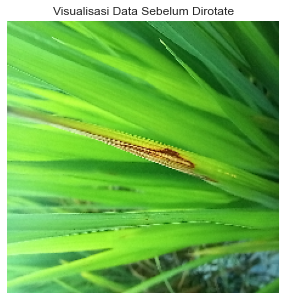

In [26]:
# Ambil satu gambar dari kelas tertentu (misal kelas pertama)
class_names = sorted(os.listdir(main_path))
class_name = class_names[0]
class_path = os.path.join(main_path, class_name)
image_file = sorted(os.listdir(class_path))[0]  # ambil gambar pertama
image_path = os.path.join(class_path, image_file)

# Load gambar asli
original_img = load_img(image_path, target_size=(224, 224))
original_arr = img_to_array(original_img)

# Tampilkan gambar asli
plt.figure(figsize=(5, 5))
plt.imshow(original_arr.astype('uint8'))
plt.title(f"Visualisasi Data Sebelum Dirotate")
plt.axis("off")
plt.show()

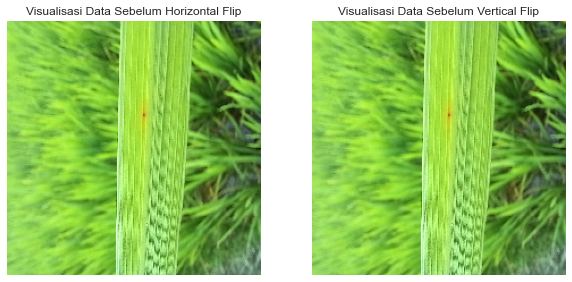

In [27]:
class_names = sorted(os.listdir(main_path))
class_name = class_names[1]
class_path = os.path.join(main_path, class_name)
image_file = sorted(os.listdir(class_path))[0]  # ambil gambar pertama
image_path = os.path.join(class_path, image_file)

# Load gambar asli
original_img = load_img(image_path, target_size=(224, 224))
original_arr = img_to_array(original_img)

# Tampilkan gambar asli
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(original_arr.astype('uint8'))
plt.title(f"Visualisasi Data Sebelum Horizontal Flip")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(original_arr.astype('uint8'))
plt.title(f"Visualisasi Data Sebelum Vertical Flip")
plt.axis("off")

plt.show()

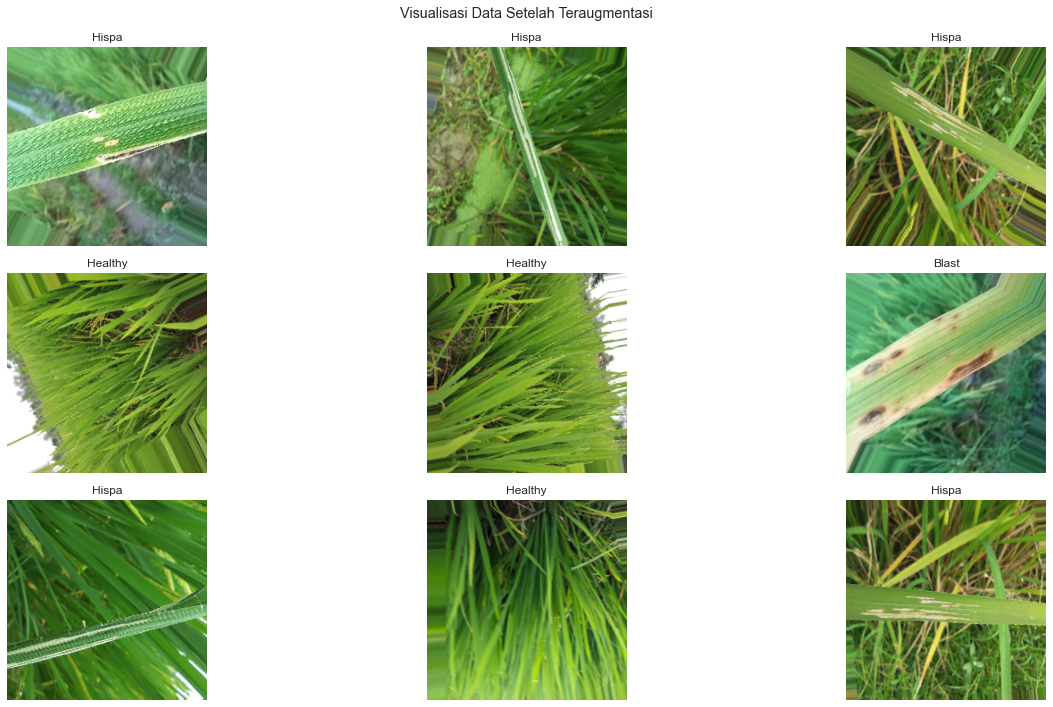

In [28]:
plt.figure(figsize=(20, 10))
plt.suptitle('Visualisasi Data Setelah Teraugmentasi')
images, labels = train_set.next()

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image_to_display = (images[i] + 1.0) / 2.0

    plt.imshow(image_to_display)
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")
    
plt.tight_layout()
plt.show()


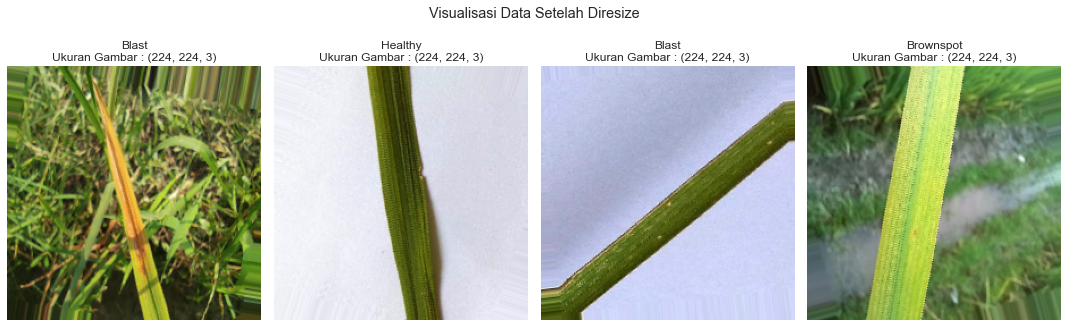

In [29]:
# Membuat figure dengan 4 subplot dalam satu baris
plt.figure(figsize=(15, 5))
plt.suptitle('Visualisasi Data Setelah Diresize')

for i in range(4):
    img, label = train_set.next()
    plt.subplot(1, 4, i+1)
    
    img_display = img[i]
    img_display = (img_display + 1.0) / 2.0

    img_shape = img_display.shape
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f'{class_names[tf.argmax(label[i])]}\nUkuran Gambar : {img_shape}')

plt.tight_layout()
plt.show()


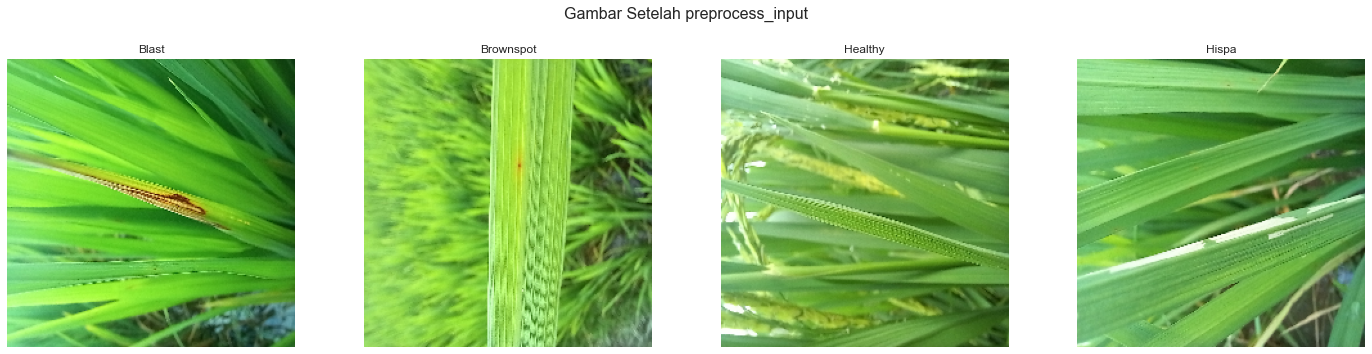

===== ARRAY SETELAH preprocess_input =====

[Blast]
➤ Array :
[[[ 0.2  0.2 -0.9]
  [ 0.3  0.3 -0.8]
  [ 0.4  0.5 -0.8]]

 [[-0.4 -0.7 -1. ]
  [-0.5 -0.8 -1. ]
  [ 0.3  0.1 -0.7]]

 [[ 0.6  0.3 -0.3]
  [ 1.   0.8  0.2]
  [ 1.   0.9  0.3]]]

[Brownspot]
➤ Array :
[[[ 0.4  0.9  0. ]
  [ 0.4  0.8 -0. ]
  [ 0.3  0.8 -0.2]]

 [[ 0.3  0.8 -0.1]
  [ 0.3  0.8 -0.1]
  [ 0.3  0.8 -0.2]]

 [[ 0.5  1.   0.1]
  [ 0.2  0.7 -0.2]
  [ 0.3  0.8 -0.2]]]

[Healthy]
➤ Array :
[[[-0.1  0.3 -0.6]
  [-0.2  0.3 -0.6]
  [-0.2  0.2 -0.7]]

 [[-0.3  0.2 -0.8]
  [-0.3  0.1 -0.8]
  [-0.3  0.1 -0.8]]

 [[-0.4  0.1 -0.8]
  [-0.4  0.  -0.9]
  [-0.4  0.1 -0.8]]]

[Hispa]
➤ Array :
[[[-0.3  0.2 -0.6]
  [-0.3  0.2 -0.6]
  [-0.3  0.2 -0.6]]

 [[-0.3  0.2 -0.6]
  [-0.3  0.2 -0.6]
  [-0.3  0.2 -0.6]]

 [[-0.3  0.2 -0.6]
  [-0.4  0.2 -0.6]
  [-0.3  0.3 -0.6]]]



In [30]:
# Proses normalisasi
processed_arrays = [preprocess_input(arr.copy()) for arr in original_arrays]

# Tampilkan gambar hasil preprocess (bisa terlihat agak gelap)
plt.figure(figsize=(5 * n_classes, 5))
plt.suptitle("Gambar Setelah preprocess_input", fontsize=16)

for i in range(n_classes):
    img = processed_arrays[i]
    img_display = (img + 1.0) / 2.0  # skala balik ke 0–1 untuk ditampilkan
    plt.subplot(1, n_classes, i + 1)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"{selected_class_names[i]}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Tampilkan array 3x3 setelah preprocessing
print("===== ARRAY SETELAH preprocess_input =====\n")
for i in range(n_classes):
    print(f"[{selected_class_names[i]}]")
    print("➤ Array :")
    print(np.round(processed_arrays[i][100:103, 100:103], 2))
    print()

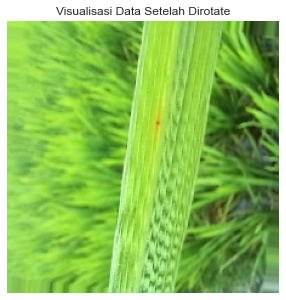

In [31]:
# ImageDataGenerator dengan rotasi
rotate_aug = ImageDataGenerator(rotation_range=30)

# Ubah array menjadi batch dengan dimensi (1, 224, 224, 3)
original_arr_batch = np.expand_dims(original_arr, axis=0)

# Augmentasi: ambil 1 gambar hasil rotate
aug_iter = rotate_aug.flow(original_arr_batch, batch_size=1)
rotated_img = next(aug_iter)[0].astype('uint8')  # ambil hasilnya dan ubah ke uint8

# Tampilkan gambar yang sudah di-rotate
plt.figure(figsize=(5, 5))
plt.imshow(rotated_img)
plt.title(f"Visualisasi Data Setelah Dirotate")
plt.axis("off")
plt.show()

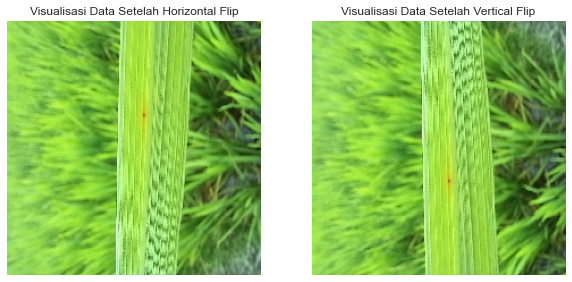

In [32]:
# ImageDataGenerator dengan flip horizontal
horflip_aug = ImageDataGenerator(horizontal_flip=True)
verflip_aug = ImageDataGenerator(vertical_flip=True)

# Ubah array menjadi batch (1, 224, 224, 3)
original_arr_batch = np.expand_dims(original_arr, axis=0)

# Augmentasi: ambil satu gambar yang sudah di-flip
aug_iterhor = horflip_aug.flow(original_arr_batch, batch_size=1)
aug_iterver = verflip_aug.flow(original_arr_batch, batch_size=1)
flipped_imghor = next(aug_iterhor)[0].astype('uint8')
flipped_imgver = next(aug_iterver)[0].astype('uint8')

# Tampilkan gambar yang sudah di-flip
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(flipped_imghor)
plt.title(f"Visualisasi Data Setelah Horizontal Flip")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(flipped_imgver)
plt.title(f"Visualisasi Data Setelah Vertical Flip")
plt.axis("off")
plt.show()

#### Jumlah Data setiap kelas dalam **Training**, **Testing** dan **Validation**

# Modelling
## Modelling dengan model MobileNetV1

In [33]:
# Load MobileNetV1 base model tanpa fully connected layer
model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in model.layers:
    layer.trainable = False

# Bangun model dengan Fully Connected Layer untuk rasio 7:2:1
modelv1r1 = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),  # Pooling untuk mengurangi dimensi
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.BatchNormalization(),  # Menormalkan distribusi data antar batch
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(4, activation='softmax')  # Output layer dengan 4 kelas
])

# Bangun model dengan Fully Connected Layer untuk rasio 8:1:1
modelv1r2 = models.Sequential([
    model,
    layers.GlobalAveragePooling2D(),  # Pooling untuk mengurangi dimensi
    layers.Dense(256, activation='relu'),  # Fully connected layer
    layers.BatchNormalization(),  # Menormalkan distribusi data antar batch
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(4, activation='softmax')  # Output layer dengan 4 kelas
])

In [34]:
modelv1r1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [35]:
modelv1r2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [36]:
modelv1r1.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelv1r2.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Fungsi untuk menghentikan epoch ketika accuracy sudah mencapai 97% atau validation accuracy sudah mencapai 95% dan fungsi untuk menghentikan epoch ketika tidak ada peningkatan akurasi model

In [37]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        
        if acc > 0.97 and val_acc > 0.95:
            print(f"\n🔹 Training dihentikan pada epoch {epoch+1} karena akurasi ({acc:.4f}) dan val_akurasi ({val_acc:.4f}) sudah tinggi.")
            self.model.stop_training = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

#### Proses melatih data dari model yang telah dibuat
- Dengan iterasi sebanyak 20
- Menggunakan data train dan validation dari rasio 7:2:1 dan 8:1:1

In [38]:
hasilr1 = modelv1r1.fit(train_set, epochs=20, 
                     validation_data=val_set, 
                     verbose=1, 
                     callbacks=[myCallback(), 
                                early_stopping])

Epoch 1/20
44/44 [==============================] - 63s 1s/step - loss: 1.0164 - accuracy: 0.6379 - val_loss: 0.5470 - val_accuracy: 0.7750
Epoch 2/20
44/44 [==============================] - 44s 1s/step - loss: 0.5811 - accuracy: 0.7993 - val_loss: 0.4247 - val_accuracy: 0.8300
Epoch 3/20
44/44 [==============================] - 42s 945ms/step - loss: 0.4562 - accuracy: 0.8157 - val_loss: 0.4174 - val_accuracy: 0.8750
Epoch 4/20
44/44 [==============================] - 42s 950ms/step - loss: 0.3751 - accuracy: 0.8693 - val_loss: 0.3068 - val_accuracy: 0.9000
Epoch 5/20
44/44 [==============================] - 44s 997ms/step - loss: 0.3217 - accuracy: 0.8743 - val_loss: 0.3273 - val_accuracy: 0.8950
Epoch 6/20
44/44 [==============================] - 43s 969ms/step - loss: 0.3314 - accuracy: 0.8664 - val_loss: 0.2572 - val_accuracy: 0.9000
Epoch 7/20
44/44 [==============================] - 42s 964ms/step - loss: 0.2700 - accuracy: 0.9043 - val_loss: 0.2156 - val_accuracy: 0.9200
Epoch

In [39]:
hasilr2 = modelv1r2.fit(train_set2, epochs=20, 
                     validation_data=val_set2, 
                     verbose=1, 
                     callbacks=[myCallback(), 
                                early_stopping])

Epoch 1/20
50/50 [==============================] - 72s 1s/step - loss: 0.9809 - accuracy: 0.6562 - val_loss: 0.7066 - val_accuracy: 0.7550
Epoch 2/20
50/50 [==============================] - 47s 938ms/step - loss: 0.5527 - accuracy: 0.7862 - val_loss: 0.4836 - val_accuracy: 0.8250
Epoch 3/20
50/50 [==============================] - 47s 943ms/step - loss: 0.4363 - accuracy: 0.8300 - val_loss: 0.4692 - val_accuracy: 0.8400
Epoch 4/20
50/50 [==============================] - 46s 922ms/step - loss: 0.3641 - accuracy: 0.8606 - val_loss: 0.3953 - val_accuracy: 0.9000
Epoch 5/20
50/50 [==============================] - 47s 938ms/step - loss: 0.3493 - accuracy: 0.8737 - val_loss: 0.3573 - val_accuracy: 0.8900
Epoch 6/20
50/50 [==============================] - 47s 944ms/step - loss: 0.3116 - accuracy: 0.8881 - val_loss: 0.3730 - val_accuracy: 0.8900
Epoch 7/20
50/50 [==============================] - 47s 942ms/step - loss: 0.2780 - accuracy: 0.8969 - val_loss: 0.3463 - val_accuracy: 0.8850
Ep

## Evaluasi

In [40]:
# Evaluasi Data Testing

test_evaluater1 = modelv1r1.evaluate(test_set, verbose=0)
test_evaluater2 = modelv1r2.evaluate(test_set2, verbose=0)

val_evaluater1 = modelv1r1.evaluate(val_set, verbose=0)
val_evaluater2 = modelv1r2.evaluate(val_set2, verbose=0)

print("Evaluasi Model MobileNetV1 dengan rasio 7:2:1\n")
print(f'Test loss           : {test_evaluater1[0]}')
print(f'Validation loss     : {val_evaluater1[0]}\n')
print(f'Test accuracy       : {test_evaluater1[1]}')
print(f'Validation accuracy : {val_evaluater1[1]}')

print("\nEvaluasi Model MobileNetV1 dengan rasio 8:1:1\n")
print(f'Test loss           : {test_evaluater2[0]}')
print(f'Validation loss     : {val_evaluater2[0]}\n')
print(f'Test accuracy       : {test_evaluater2[1]}')
print(f'Validation accuracy : {val_evaluater2[1]}')

Evaluasi Model MobileNetV1 dengan rasio 7:2:1

Test loss           : 0.25817787647247314
Validation loss     : 0.19746017456054688

Test accuracy       : 0.9275000095367432
Validation accuracy : 0.9200000166893005

Evaluasi Model MobileNetV1 dengan rasio 8:1:1

Test loss           : 0.1957402229309082
Validation loss     : 0.33786818385124207

Test accuracy       : 0.925000011920929
Validation accuracy : 0.9049999713897705


### Visualisasi perbandingan **Akurasi** dan **Loss** Model


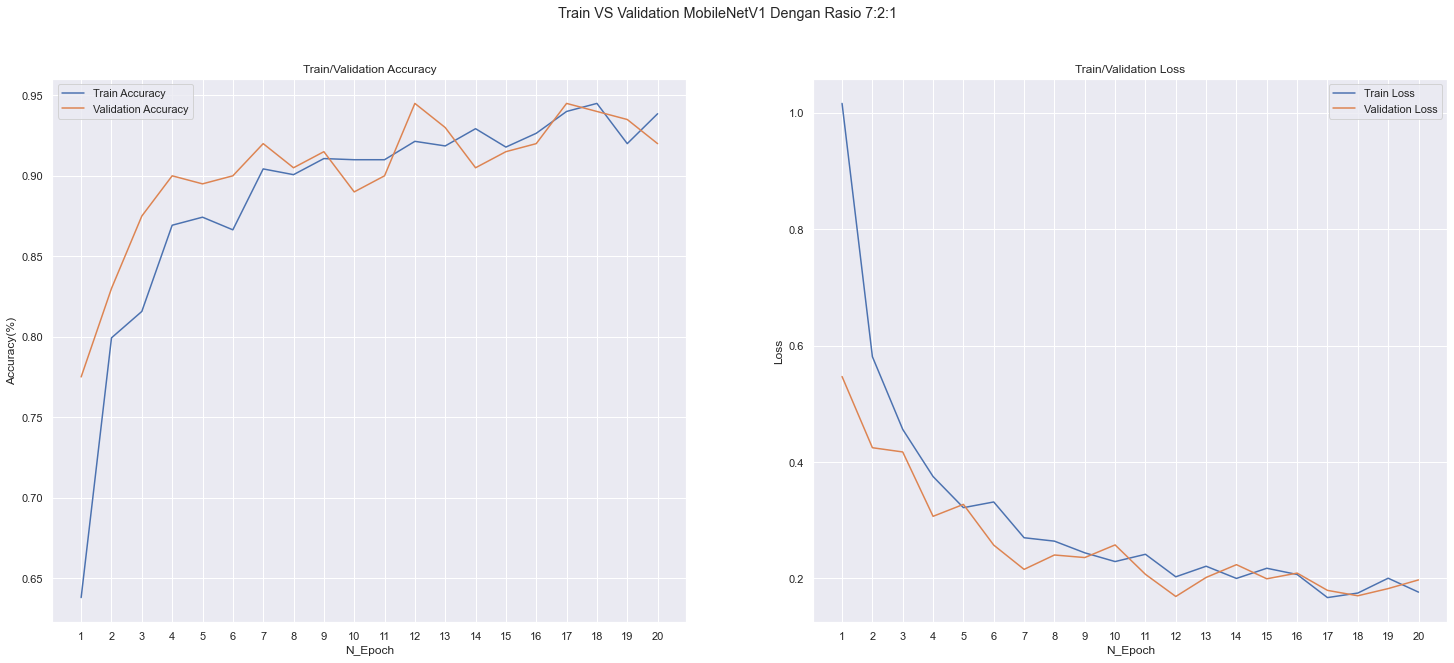

In [41]:
# Visualisasi akurasi dan loss dari fitting

epochr1 = [i+1 for i in range(len(hasilr1.history['accuracy']))]


plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation MobileNetV1 Dengan Rasio 7:2:1')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epochr1,y = hasilr1.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epochr1,y = hasilr1.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epochr1)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epochr1,y = hasilr1.history['loss'],label ='Train Loss')
sns.lineplot(x=epochr1,y = hasilr1.history['val_loss'],label ='Validation Loss')

plt.xticks(epochr1)
plt.title("Train/Validation Loss")
plt.xlabel('N_Epoch')
plt.ylabel('Loss')
plt.show()

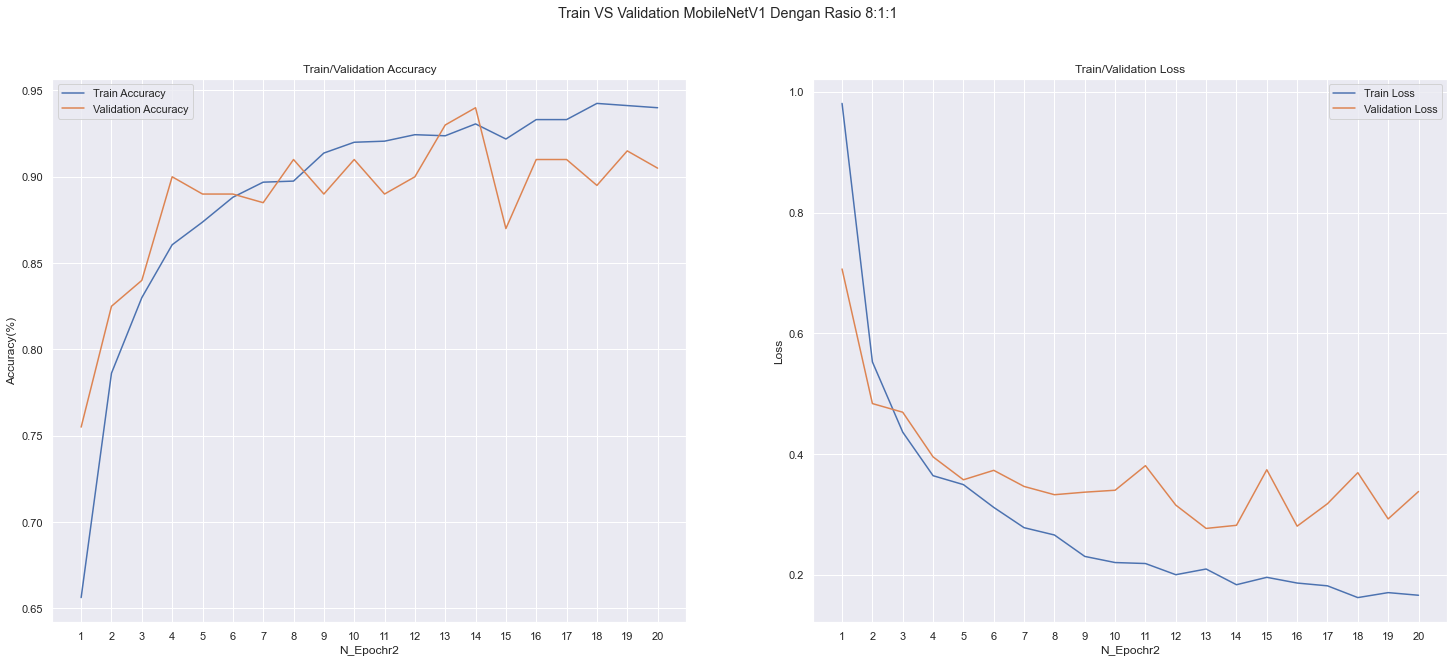

In [42]:
# Visualisasi akurasi dan loss dari fitting

epochr2 = [i+1 for i in range(len(hasilr2.history['accuracy']))]


plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation MobileNetV1 Dengan Rasio 8:1:1')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epochr2,y = hasilr2.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epochr2,y = hasilr2.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epochr2)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epochr2')
plt.title("Train/Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epochr2,y = hasilr2.history['loss'],label ='Train Loss')
sns.lineplot(x=epochr2,y = hasilr2.history['val_loss'],label ='Validation Loss')

plt.xticks(epochr2)
plt.title("Train/Validation Loss")
plt.xlabel('N_Epochr2')
plt.ylabel('Loss')
plt.show()

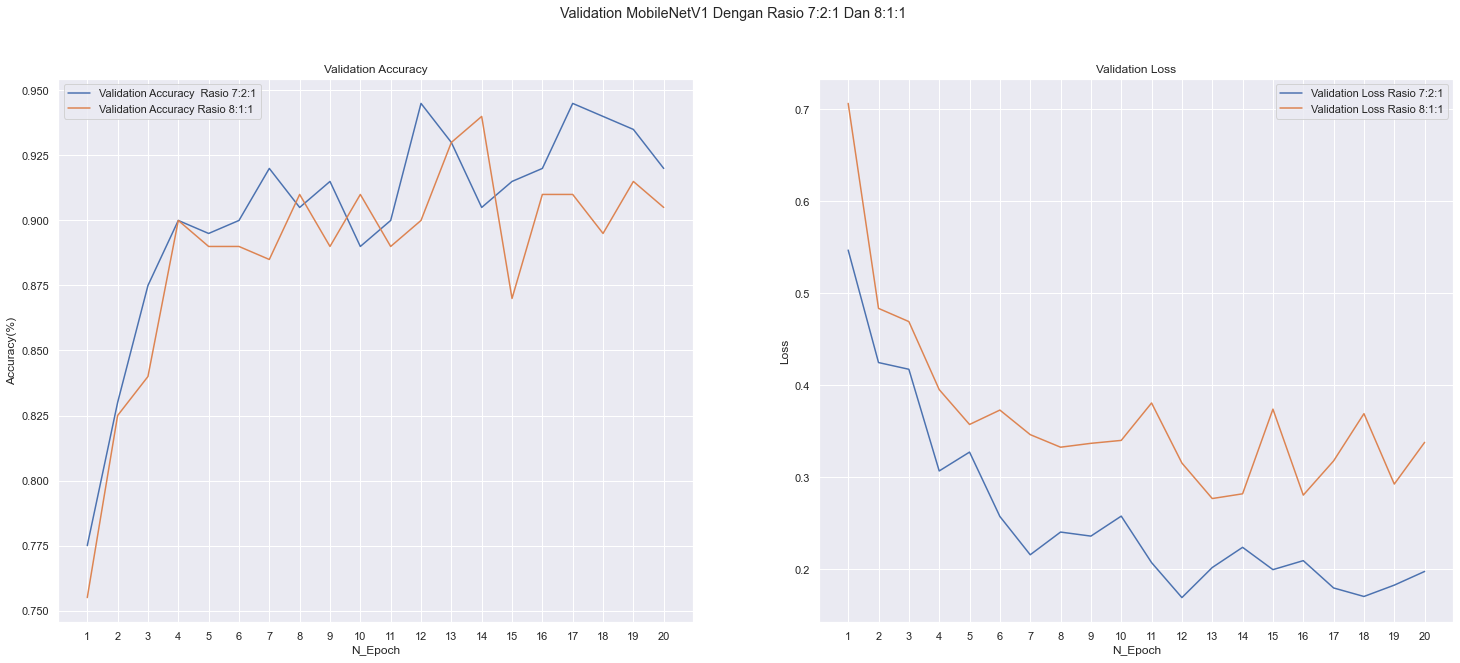

In [43]:
 # Visualisasi akurasi dan loss dari kedua rasio

plt.figure(figsize=(25, 10))
plt.suptitle('Validation MobileNetV1 Dengan Rasio 7:2:1 Dan 8:1:1')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epochr1,y = hasilr1.history['val_accuracy'],label ='Validation Accuracy  Rasio 7:2:1')
sns.lineplot(x=epochr2,y = hasilr2.history['val_accuracy'],label ='Validation Accuracy Rasio 8:1:1')

plt.xticks(epochr1)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epochr1,y = hasilr1.history['val_loss'],label ='Validation Loss Rasio 7:2:1')
sns.lineplot(x=epochr2,y = hasilr2.history['val_loss'],label ='Validation Loss Rasio 8:1:1')

plt.xticks(epochr1)
plt.title("Validation Loss")
plt.xlabel('N_Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
# # Save Model
# model.save('Model Saved')
# model.save('Model Saved.h5')

# Prediksi
### Visualisai Hasil prediksi yang benar

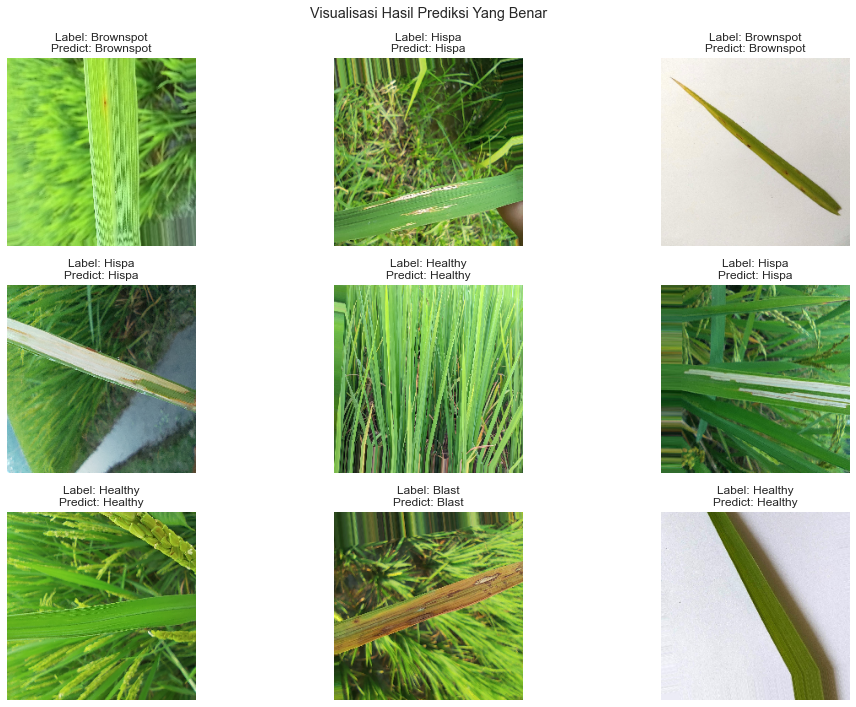

In [45]:
# Ambil batch gambar dan label
image, label = next(iter(test_set))

# Plot hanya prediksi yang benar
plt.figure(figsize=(15, 10))
plt.suptitle('Visualisasi Hasil Prediksi Yang Benar')
count = 0  # Counter untuk subplot

for i in range(len(image)):
    # Label sebenarnya dan prediksi
    true_label = np.argmax(label[i])
    y_pred = np.argmax(modelv1r2.predict(image[i][None, ...], verbose=0))

    # Periksa apakah prediksi benar
    if y_pred == true_label:
        count += 1
        plt.subplot(3, 3, count)
        plt.axis('off')
        image_to_display = (image[i] + 1.0) / 2.0
        plt.imshow(tf.squeeze(image_to_display))
        plt.title(f'Label: {class_names[true_label]}\nPredict: {class_names[y_pred]}')

    # Hentikan jika sudah menampilkan 9 gambar
    if count == 9:
        break

plt.tight_layout()
plt.show()


### Visualisasi Hasil prediksi yang salah

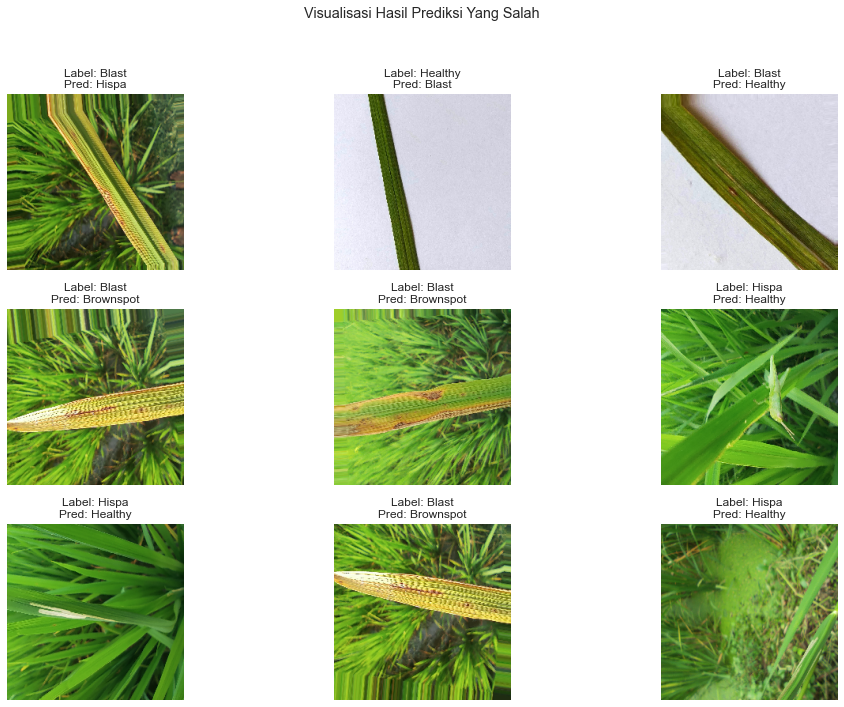

In [46]:
# Siapkan list untuk menyimpan gambar dan label yang salah prediksi
wrong_images = []
wrong_labels = []
wrong_preds = []

# Reset iterator agar mulai dari awal test set
test_iter = iter(test_set2)

# Loop sampai mendapat 9 kesalahan atau data habis
while len(wrong_images) < 9:
    try:
        # Ambil satu batch
        images, labels = next(test_iter)
        
        # Loop per gambar dalam batch
        for i in range(len(images)):
            true_label = np.argmax(labels[i])
            pred = np.argmax(modelv1r2.predict(images[i][None, ...], verbose=0))
            
            if pred != true_label:
                wrong_images.append(images[i])
                wrong_labels.append(true_label)
                wrong_preds.append(pred)

            if len(wrong_images) == 9:
                break
    except StopIteration:
        break  # Tidak ada data lagi di iterator

# Visualisasi hasil salah prediksi
plt.figure(figsize=(15, 10))
plt.suptitle('Visualisasi Hasil Prediksi Yang Salah')

for i in range(len(wrong_images)):
    plt.subplot(3, 3, i + 1)
    img = (wrong_images[i] + 1.0) / 2.0
    plt.imshow(tf.squeeze(img))
    plt.axis('off')
    plt.title(f'Label: {class_names[wrong_labels[i]]}\nPred: {class_names[wrong_preds[i]]}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [47]:
# Untuk menyimpan hasil testing dan predict dari data testing Model MObileNetV1 dengan rasi0 7:2:1
y_testr1 = []
y_predr1 = []

for i in range(len(test_set)) :
    x,y = test_set.next()
    for j in range(len(y)) :
        y_testr1.append(class_names[tf.argmax(y[j])])
        y_predr1.append(class_names[np.argmax(modelv1r1.predict(x[j][None,...],verbose=0))])

In [48]:
# Untuk menyimpan hasil testing dan predict dari data testing Model MObileNetV1 dengan rasi0 8:1:1
y_testr2 = []
y_predr2 = []

for i in range(len(test_set2)) :
    x,y = test_set2.next()
    for j in range(len(y)) :
        y_testr2.append(class_names[tf.argmax(y[j])])
        y_predr2.append(class_names[np.argmax(modelv1r2.predict(x[j][None,...],verbose=0))])

### Confusion Matrix

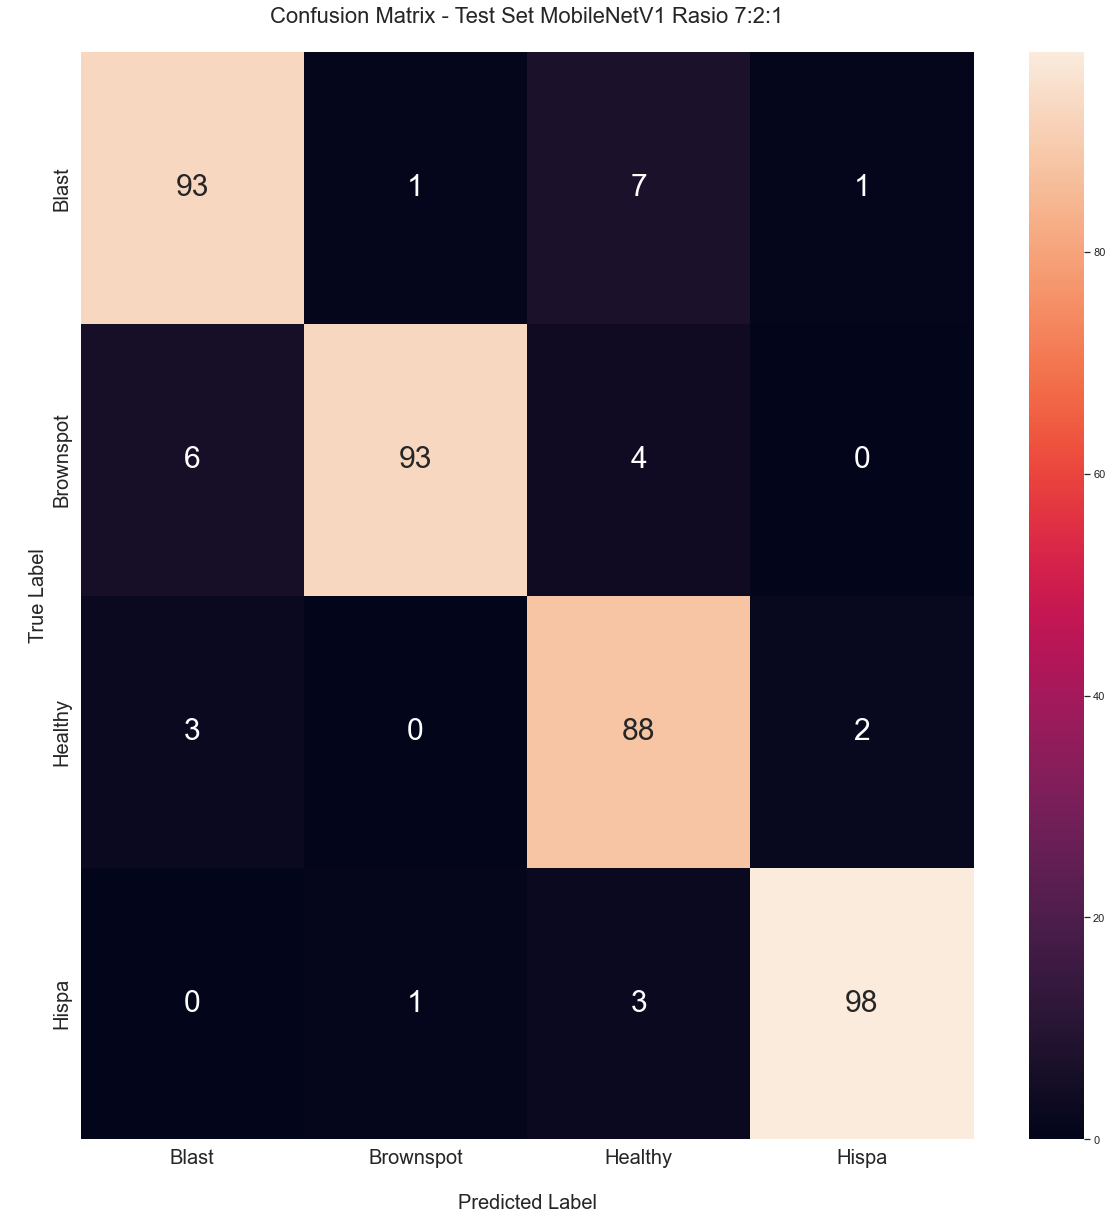

In [49]:
# Visualisasi Heatmap untuk Confusion Matrix Model MobileNetV1 Dengan Rasio 7:2:1

plt.figure(figsize=(20, 20))
cm = confusion_matrix(y_testr1, y_predr1)

sns.heatmap(cm, annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names, annot_kws={"size": 30})
plt.title("Confusion Matrix - Test Set MobileNetV1 Rasio 7:2:1\n", fontsize=22)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("\nPredicted Label", fontsize=20)
plt.ylabel("\nTrue Label", fontsize=20)
plt.show()

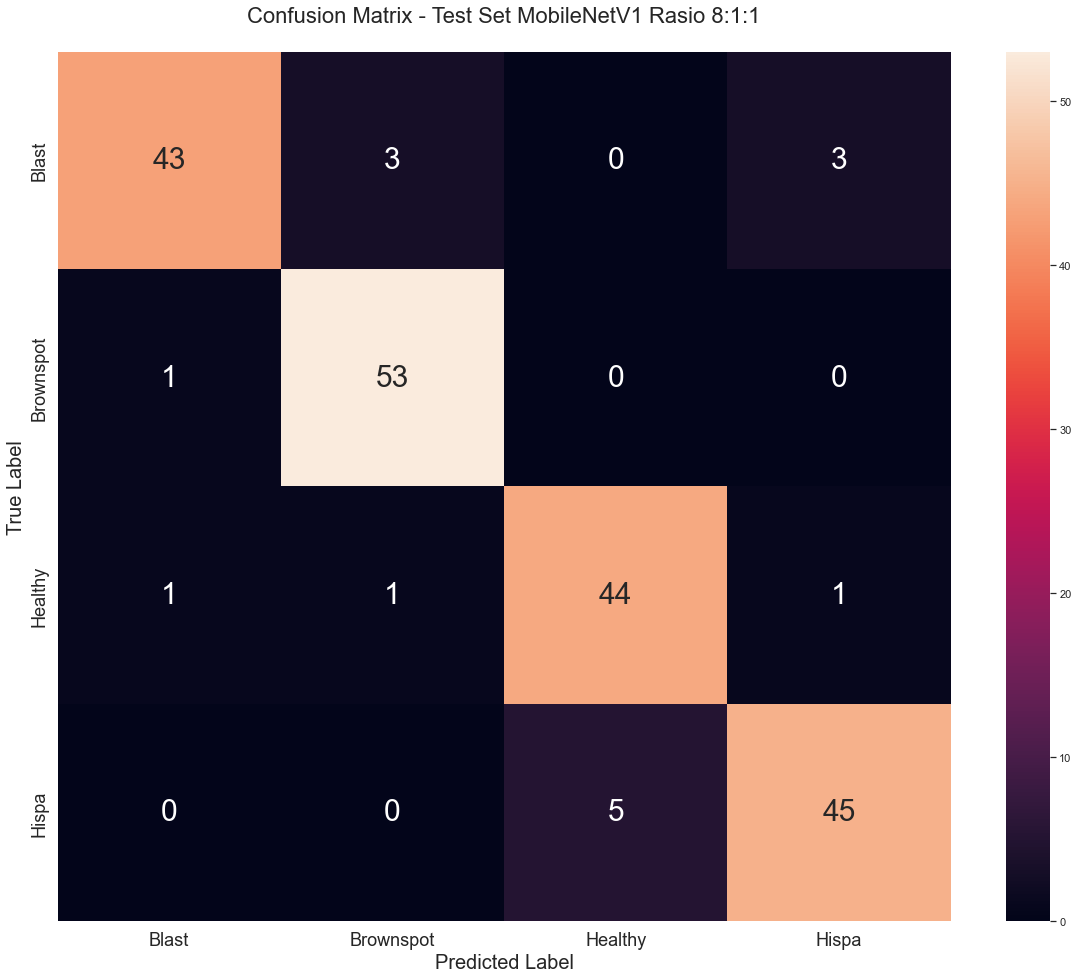

In [57]:
# Visualisasi Heatmap untuk Confusion Matrix Model MobileNetV1 Dengan Rasio 8:1:1

plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_testr2, y_predr2)

sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names, annot_kws={"size": 30})
plt.title("Confusion Matrix - Test Set MobileNetV1 Rasio 8:1:1\n", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.show()

### Classification Report

In [51]:
#Classification Report MobileNetV1

print('Classification Report MobileNetV1 Rasio 7:2:1\n')
print(classification_report(y_testr1, y_predr1, target_names=class_names))

print('\nClassification Report MobileNetV1 Rasio 8:1:1\n')
print(classification_report(y_testr2, y_predr2, target_names=class_names))

Classification Report MobileNetV1 Rasio 7:2:1

              precision    recall  f1-score   support

       Blast       0.91      0.91      0.91       102
   Brownspot       0.98      0.90      0.94       103
     Healthy       0.86      0.95      0.90        93
       Hispa       0.97      0.96      0.97       102

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400


Classification Report MobileNetV1 Rasio 8:1:1

              precision    recall  f1-score   support

       Blast       0.96      0.88      0.91        49
   Brownspot       0.93      0.98      0.95        54
     Healthy       0.90      0.94      0.92        47
       Hispa       0.92      0.90      0.91        50

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200

